In [250]:
'''Titanic Survival Analysis

Data from the Kaggle Titanic Competition can be found at:
https://www.kaggle.com/c/titanic/overview

The Notebook with all outputs can be found at the following Repo:
https://github.com/BeastOrchestra/DataScience/blob/main/titanic/Titanic_Kaggle.ipynb

The problem is Binary classification prediction of whether or not a passenger on the
Titantic died in the disaster or not.

'''

'Titanic Survival Analysis\n\nData from the Kaggle Titanic Competition can be found at:\nhttps://www.kaggle.com/c/titanic/overview\n\nThe Notebook with all outputs can be found at the following Repo:\nhttps://github.com/BeastOrchestra/DataScience/blob/main/titanic/Titanic_Kaggle.ipynb\n\nThe problem is Binary classification prediction of whether or not a passenger on the\nTitantic died in the disaster or not.\n\n'

In [251]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)
# Grab data

dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

# Look at high level data features (All Passengers in Training Data)
print(dftrain.info())
dftrain.describe()

# The data occupies 83.7KB of memory

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


[Text(0.5, 0, 'PassengerId'),
 Text(1.5, 0, 'Survived'),
 Text(2.5, 0, 'Pclass'),
 Text(3.5, 0, 'Age'),
 Text(4.5, 0, 'SibSp'),
 Text(5.5, 0, 'Parch'),
 Text(6.5, 0, 'Fare')]

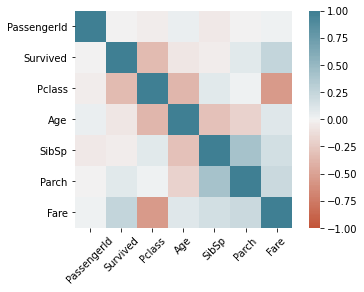

In [252]:
cmat = dftrain.corr()
ax = sns.heatmap(
    cmat,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45)

Percent Survival In Train set: 38.38383838383838 %
Percent Women Survived:  74.20382165605096 %
Percent Men Survived:  18.890814558058924 %


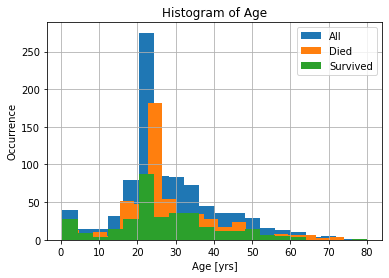

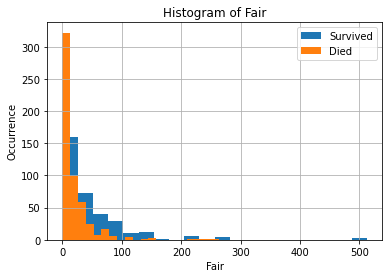

In [253]:
# Look at age and gender as factors
All=len(dftrain)
Survived=len(dftrain[dftrain.Survived == 1])
print('Percent Survival In Train set:',100*Survived/All,'%')

# need to address NaN values in age. Will replace nan with mode values.
ModeAge = dftrain.Age[dftrain.Age.isna() == False].mode()
dftrain['Age'] = dftrain['Age'].fillna(ModeAge.values[0])

plt.hist(dftrain.Age, bins = 20)
plt.hist(dftrain[dftrain.Survived == 0].Age, bins = 20)
plt.hist(dftrain[dftrain.Survived == 1].Age, bins = 20)

plt.title('Histogram of Age')
plt.xlabel('Age [yrs]')
plt.ylabel('Occurrence')
plt.legend(['All','Died','Survived'])
plt.grid()
plt.show()

# Histogram of Fare for Survivors vs. NonSurvivors
plt.hist(dftrain[dftrain.Survived == 1].Fare, bins = 20)
plt.hist(dftrain[dftrain.Survived == 0].Fare, bins = 20)
plt.title('Histogram of Fair')
plt.xlabel('Fair')
plt.ylabel('Occurrence')
plt.legend(['Survived','Died'])
plt.grid()
plt.show()

Women = dftrain[dftrain.Sex == 'female'].Sex.count()
Men = dftrain[dftrain.Sex == 'male'].Sex.count()
SurvivingWomen = dftrain[(dftrain.Sex == 'female') & (dftrain.Survived == 1)].Sex.count()
SurvivingMen = dftrain[(dftrain.Sex == 'male') & (dftrain.Survived == 1)].Sex.count()

print('Percent Women Survived: ', 100*SurvivingWomen/Women,'%')
print('Percent Men Survived: ', 100*SurvivingMen/Men,'%')

# Remove Features with no bearing on model prediction
dftrain = dftrain.drop(columns=['Name','Ticket'])

# Clean categorical columns
dftrain.Sex = LabelBinarizer().fit_transform(dftrain.Sex)

# One hot encode Cabins
dftrain.Cabin = dftrain.Cabin.fillna('Unknown')
Cabin_str = dftrain["Cabin"].str[0]
Cabin_str.value_counts()
for i in Cabin_str.unique():
    dftrain['cabin_'+i]=0
for i in range(len(dftrain)):
    dftrain['cabin_' + Cabin_str[i]][i] = 1
# One hot encode Embark locations
dftrain.Embarked = dftrain.Embarked.fillna('Unknown')
Embark_str = dftrain["Embarked"].str[0]
Embark_str.value_counts()
for i in Embark_str.unique():
    dftrain['embarked_'+i]=0
for i in range(len(dftrain)):
    dftrain['embarked_' + Embark_str[i]][i] = 1

# Remove Old columns
dftrain = dftrain.drop(columns=['Cabin','Embarked'])

# Generate Test/Train data
y=dftrain.Survived
X=dftrain.drop(columns ='Survived')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

In [254]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, plot_confusion_matrix

# Init classifier
xgb_cl = xgb.XGBClassifier(max_depth=1, eval_metric='mae',seed=42)
# Fit
xgb_cl.fit(X_train, y_train)
y_pred = xgb_cl.predict(X_test)

# Model Outputs
acc=accuracy_score(y_test,y_pred)
print('Initial Model Accuracy: ', acc)

Initial Model Accuracy:  0.8044692737430168


Max F1 of: 0.8425925925925926
Test Precision:  0.8198198198198198
Test Recall:  0.8666666666666667
Test F1:  0.8425925925925926
Test Accuracy:  0.8100558659217877


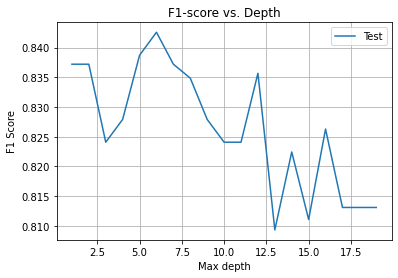

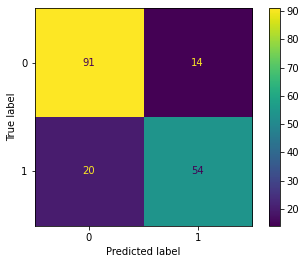

In [255]:
scoreTest=[]
for i in range(1,20):
    xgb_cl = xgb.XGBClassifier(max_depth=i, eval_metric='mae',seed=42)
    # Fit
    xgb_cl.fit(X_train, y_train)
    y_pred = xgb_cl.predict(X_test)
    pre, rec, f1, sup = precision_recall_fscore_support(y_test,y_pred)
    acc=accuracy_score(y_test,y_pred)
    scoreTest.append(f1[0])

print('Max F1 of:', max(scoreTest))

plt.plot(range(1,20),scoreTest)
plt.xlabel('Max depth')
plt.ylabel('F1 Score')
plt.grid()
plt.title('F1-score vs. Depth')
plt.legend(['Test'])

xgb_cl = xgb.XGBClassifier(max_depth=6, eval_metric='mae',seed=42)
xgb_cl.fit(X_train, y_train)
y_pred = xgb_cl.predict(X_test)
pre, rec, f1, sup = precision_recall_fscore_support(y_test,y_pred)
acc=accuracy_score(y_test,y_pred)
plot_confusion_matrix(xgb_cl,X_test,y_test)
print('Test Precision: ',pre[0])
print('Test Recall: ',rec[0])
print('Test F1: ',f1[0])
print('Test Accuracy: ',acc)

In [256]:
''' Conclusion and Analysis
Data was imported from the Kaggle competitions Titanic dataset.
Exploratory data analysis provides some interesting features of the data.
As a population, women enjoyed higher survival statistics then men.
The role of fare on Survival also was studied,
Travelers with lower fares suffered a higher mortality rate.

The data required a modest degree of data cleaning to make it model ready.
Categorical variables were cleaned by utilizing one hot encoding. Categorical features
with a high degree of variability were basketed to reduce the number of possible values.
Cabin was basketed according to prefix values instead of the full string. To address NaN age
values the mode value was used to fill blank values.

The model was based on XGBoost architecture. Initially a max depth of 1 was selected.
Since the classification problem is binary (survival or death) the F1 metrics can be leveraged.
To optimize the model based on max depth, a range of depths was used and test data was evaluated.
The maximum F1 value was found at max depth of six. A confusion matrix and various metrics
are provided for this model'''



' Conclusion and Analysis\nData was imported from the Kaggle competitions Titanic dataset.\nExploratory data analysis provides some interesting features of the data.\nAs a population, women enjoyed higher survival statistics then men.\nThe role of fare on Survival also was studied,\nTravelers with lower fares suffered a higher mortality rate.\n\nThe data required a modest degree of data cleaning to make it model ready.\nCategorical variables were cleaned by utilizing one hot encoding. Categorical features\nwith a high degree of variability were basketed to reduce the number of possible values.\nCabin was basketed according to prefix values instead of the full string. To address NaN age\nvalues the mode value was used to fill blank values.\n\nThe model was based on XGBoost architecture. Initially a max depth of 1 was selected.\nSince the classification problem is binary (survival or death) the F1 metrics can be leveraged.\nTo optimize the model based on max depth, a range of depths was 